# Delay from arXiv publication to HEPData release

This Jupyter notebook investigates the delay between arXiv publication, indicated by creation of an [INSPIRE](https://inspirehep.net) record, and release of the first version of a corresponding [HEPData](https://www.hepdata.net) record.  A histogram is plotted of these delays for a given time period and experimental collaboration.

Written by Graeme Watt on 25th November 2022.

In [1]:
import requests
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style='whitegrid')
%matplotlib inline

Define a function to compose a relevant INSPIRE query.

In [2]:
def compose_query(collaboration='', year=0):
    """
    Compose an INSPIRE query to get records with a HEPData entry.
    """
    
    # Restrict search to a particular experimental collaboration.
    # Empty collaboration searches for papers from all four main LHC collaborations.
    if collaboration:
        query = 'collaboration:{}'.format(collaboration)
    else:
        query = '(collaboration:ALICE or collaboration:ATLAS or ' + \
        'collaboration:CMS or collaboration:LHCb)'
        
    # Restrict search to date-earliest greater than or equal to a particular year.
    if year:
        query += ' and de >= {}'.format(year)
    
    # Restrict search to publications that have a corresponding HEPData record.
    query += ' and external_system_identifiers.schema:HEPData'
    
    print('Query: {}'.format(query))
    return query

Define a function to calculate the delays between arXiv publication and HEPData release.

In [3]:
def calculate_delays(query):
    """
    Make a search using the INSPIRE API (https://github.com/inspirehep/rest-api-doc).
    Take the difference between the INSPIRE record creation timestamp and the last
    updated timestamp of version 1 of the corresponding HEPData record.
    """
    
    delays = []  # list of delays between arXiv and HEPData
    
    hepdata_payload = {'format': 'json', 'light': 'true', 'version': 1}
    
    url = 'https://inspirehep.net/api/literature'
    size = 1000  # assume number of results less than size, so only one page of results
    payload = {'q': query, 'size': size, 'fields': 'control_number', 'sort': 'mostrecent'}
    response = requests.get(url, params=payload).json()

    total = response['hits']['total']
    print('Total hits: {}'.format(total))
    if total > size:
        print('Error: {} > {}!'.format(total, size))
        return []
    
    hits = response['hits']['hits']
    for i, hit in enumerate(hits):  # loop over INSPIRE records
        
        inspire_id = hit['id']
        created = datetime.fromisoformat(hit['created']).replace(tzinfo=None)
        
        # Find out when version 1 of HEPData record was last updated.
        hepdata_url = 'https://www.hepdata.net/record/ins{}'.format(inspire_id)
        hepdata = requests.get(hepdata_url, hepdata_payload).json()
        datetime_format = '%a, %d %b %Y %H:%M:%S %Z'
        last_updated = datetime.strptime(hepdata['record']['last_updated'], datetime_format)
        
        delta = last_updated - created
        print('{} : https://inspirehep.net/literature/{} : delay was {} days.'.format(
            i+1, inspire_id, delta.days))
        delays.append(delta.days)

    # Remove exceptional negative delay values, e.g.
    # change of INSPIRE ID after HEPData release.
    delays = [delay for delay in delays if delay >= 0]

    return delays

Define a function to plot a histogram of the binned delays.

In [4]:
def make_plot(delays, collaboration, year):
    """
    Bin a list of delays (in days) and make a plot.
    """
    
    if not collaboration:
        collaboration = 'LHC'
    
    if year:
        period = '{} to {}'.format(year, date.today())
    if not year:
        period = 'to {}'.format(date.today())
    
    # Define bins roughly as day/week/month/quarter-year/half-year/year.
    bins = [0, 1, 7, 30, 91, 183, 365]
    binned_delays = np.digitize(sorted(delays), bins)  # list of bin indices
    
    plt.figure(facecolor='white')
    sns.histplot(binned_delays, discrete=True)
    plt.title('Delay from arXiv to HEPData for {} ({})'.format(collaboration, period))
    plt.ylabel('Number of papers')
    plt.xticks(fontsize='x-small', ticks=list(range(1, 8)),
               labels=['< 1 day', '< 1 week', '< 1 month', '< 3 months',
                       '< 6 months', '< 1 year', '> 1 year'])
    plt.savefig('delay_{}_{}.png'.format(collaboration, date.today()))
    plt.show()

Produce results from 2018 onwards, separately for the four main LHC collaborations.

In 2017, hepdata.net did not consistently update the `last_updated` timestamp when a record was finalised, so results may be unreliable, with observed negative delays.  Prior to 2017, submissions were made via the old HepData site by either experimental collaborations or HepData staff.  Starting from 2018 is therefore a better choice for meaningful results.

The `year` and `collaborations` can be changed below as you wish (see the commented-out examples).

Query: collaboration:ALICE and de >= 2018 and external_system_identifiers.schema:HEPData
Total hits: 171
1 : https://inspirehep.net/literature/2093750 : delay was 95 days.
2 : https://inspirehep.net/literature/2092559 : delay was 165 days.
3 : https://inspirehep.net/literature/2092560 : delay was 118 days.
4 : https://inspirehep.net/literature/2088954 : delay was 86 days.
5 : https://inspirehep.net/literature/2088201 : delay was 134 days.
6 : https://inspirehep.net/literature/2071861 : delay was 174 days.
7 : https://inspirehep.net/literature/2071183 : delay was 157 days.
8 : https://inspirehep.net/literature/2071184 : delay was 130 days.
9 : https://inspirehep.net/literature/2070418 : delay was 160 days.
10 : https://inspirehep.net/literature/2070420 : delay was 178 days.
11 : https://inspirehep.net/literature/2070421 : delay was 132 days.
12 : https://inspirehep.net/literature/2070434 : delay was 152 days.
13 : https://inspirehep.net/literature/2070441 : delay was 144 days.
14 : http

119 : https://inspirehep.net/literature/1737592 : delay was 296 days.
120 : https://inspirehep.net/literature/1735344 : delay was 127 days.
121 : https://inspirehep.net/literature/1735345 : delay was 191 days.
122 : https://inspirehep.net/literature/1735349 : delay was 81 days.
123 : https://inspirehep.net/literature/1735351 : delay was 114 days.
124 : https://inspirehep.net/literature/1733683 : delay was 90 days.
125 : https://inspirehep.net/literature/1733684 : delay was 1058 days.
126 : https://inspirehep.net/literature/1733689 : delay was 160 days.
127 : https://inspirehep.net/literature/1731784 : delay was 130 days.
128 : https://inspirehep.net/literature/1729529 : delay was 169 days.
129 : https://inspirehep.net/literature/1727337 : delay was 120 days.
130 : https://inspirehep.net/literature/1724934 : delay was 676 days.
131 : https://inspirehep.net/literature/1723697 : delay was 167 days.
132 : https://inspirehep.net/literature/1721729 : delay was 386 days.
133 : https://inspire

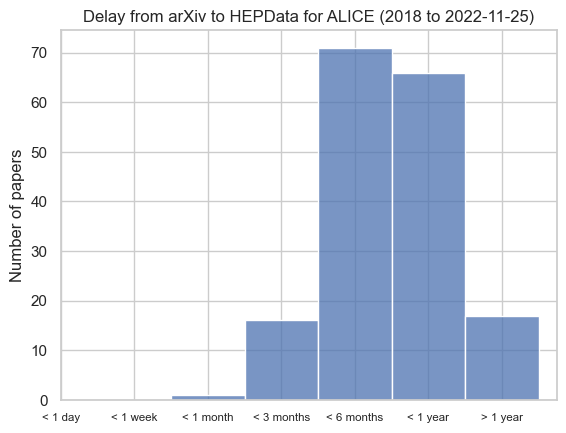

Query: collaboration:ATLAS and de >= 2018 and external_system_identifiers.schema:HEPData
Total hits: 232
1 : https://inspirehep.net/literature/2176695 : delay was 0 days.
2 : https://inspirehep.net/literature/2158974 : delay was 3 days.
3 : https://inspirehep.net/literature/2157951 : delay was 40 days.
4 : https://inspirehep.net/literature/2155171 : delay was 21 days.
5 : https://inspirehep.net/literature/2142343 : delay was 42 days.
6 : https://inspirehep.net/literature/2141752 : delay was 7 days.
7 : https://inspirehep.net/literature/2141572 : delay was 45 days.
8 : https://inspirehep.net/literature/2132750 : delay was 94 days.
9 : https://inspirehep.net/literature/2122408 : delay was 28 days.
10 : https://inspirehep.net/literature/2107940 : delay was 21 days.
11 : https://inspirehep.net/literature/2104697 : delay was 119 days.
12 : https://inspirehep.net/literature/2104770 : delay was 39 days.
13 : https://inspirehep.net/literature/2104706 : delay was 0 days.
14 : https://inspirehep

120 : https://inspirehep.net/literature/1772062 : delay was 106 days.
121 : https://inspirehep.net/literature/1772071 : delay was 557 days.
122 : https://inspirehep.net/literature/1771533 : delay was 73 days.
123 : https://inspirehep.net/literature/1768911 : delay was 406 days.
124 : https://inspirehep.net/literature/1767646 : delay was 86 days.
125 : https://inspirehep.net/literature/1767649 : delay was 3 days.
126 : https://inspirehep.net/literature/1765529 : delay was 18 days.
127 : https://inspirehep.net/literature/1764342 : delay was 61 days.
128 : https://inspirehep.net/literature/1762584 : delay was 281 days.
129 : https://inspirehep.net/literature/1762209 : delay was 218 days.
130 : https://inspirehep.net/literature/1759875 : delay was 323 days.
131 : https://inspirehep.net/literature/1759712 : delay was 105 days.
132 : https://inspirehep.net/literature/1754675 : delay was 35 days.
133 : https://inspirehep.net/literature/1752509 : delay was 289 days.
134 : https://inspirehep.ne

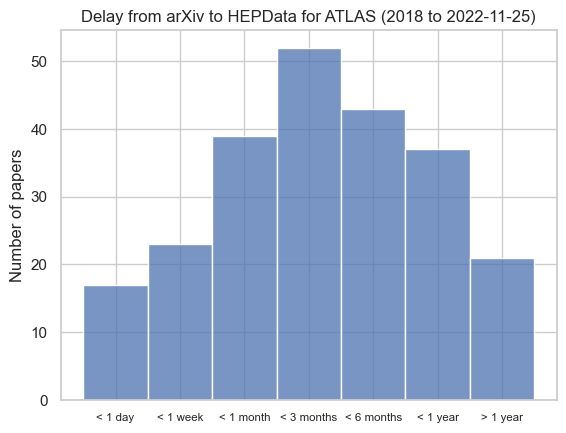

Query: collaboration:CMS and de >= 2018 and external_system_identifiers.schema:HEPData
Total hits: 319
1 : https://inspirehep.net/literature/2172990 : delay was 9 days.
2 : https://inspirehep.net/literature/2170533 : delay was 19 days.
3 : https://inspirehep.net/literature/2165920 : delay was 3 days.
4 : https://inspirehep.net/literature/2165916 : delay was 3 days.
5 : https://inspirehep.net/literature/2161685 : delay was 0 days.
6 : https://inspirehep.net/literature/2159368 : delay was 0 days.
7 : https://inspirehep.net/literature/2152227 : delay was 0 days.
8 : https://inspirehep.net/literature/2151007 : delay was 20 days.
9 : https://inspirehep.net/literature/2142913 : delay was 3 days.
10 : https://inspirehep.net/literature/2142341 : delay was 18 days.
11 : https://inspirehep.net/literature/2139823 : delay was 0 days.
12 : https://inspirehep.net/literature/2136024 : delay was 2 days.
13 : https://inspirehep.net/literature/2132366 : delay was 51 days.
14 : https://inspirehep.net/lit

121 : https://inspirehep.net/literature/1857811 : delay was 0 days.
122 : https://inspirehep.net/literature/1915909 : delay was 222 days.
123 : https://inspirehep.net/literature/1851456 : delay was 1 days.
124 : https://inspirehep.net/literature/1850544 : delay was 189 days.
125 : https://inspirehep.net/literature/1850859 : delay was 255 days.
126 : https://inspirehep.net/literature/1849964 : delay was 0 days.
127 : https://inspirehep.net/literature/1849522 : delay was 176 days.
128 : https://inspirehep.net/literature/1849180 : delay was 50 days.
129 : https://inspirehep.net/literature/1848438 : delay was 292 days.
130 : https://inspirehep.net/literature/1848440 : delay was 62 days.
131 : https://inspirehep.net/literature/1847230 : delay was 139 days.
132 : https://inspirehep.net/literature/1846987 : delay was 201 days.
133 : https://inspirehep.net/literature/1846679 : delay was 49 days.
134 : https://inspirehep.net/literature/1845579 : delay was 79 days.
135 : https://inspirehep.net/l

239 : https://inspirehep.net/literature/1726178 : delay was 605 days.
240 : https://inspirehep.net/literature/1726694 : delay was 631 days.
241 : https://inspirehep.net/literature/1734182 : delay was 265 days.
242 : https://inspirehep.net/literature/1748024 : delay was 184 days.
243 : https://inspirehep.net/literature/1766111 : delay was 912 days.
244 : https://inspirehep.net/literature/1711231 : delay was 228 days.
245 : https://inspirehep.net/literature/1711625 : delay was 296 days.
246 : https://inspirehep.net/literature/1711672 : delay was 121 days.
247 : https://inspirehep.net/literature/1711260 : delay was 81 days.
248 : https://inspirehep.net/literature/1709330 : delay was 223 days.
249 : https://inspirehep.net/literature/1709317 : delay was 290 days.
250 : https://inspirehep.net/literature/1706172 : delay was 267 days.
251 : https://inspirehep.net/literature/1704960 : delay was 258 days.
252 : https://inspirehep.net/literature/1705068 : delay was 657 days.
253 : https://inspire

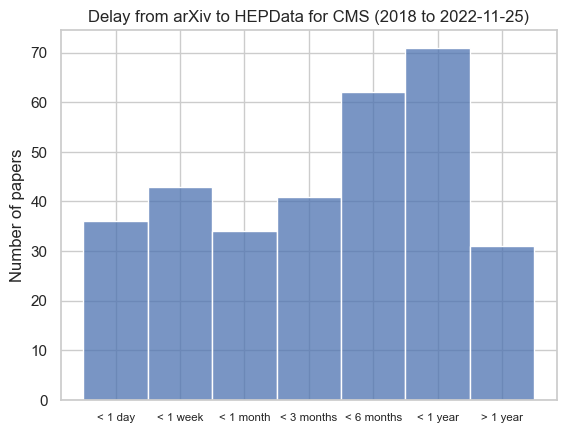

Query: collaboration:LHCb and de >= 2018 and external_system_identifiers.schema:HEPData
Total hits: 17
1 : https://inspirehep.net/literature/2084295 : delay was 55 days.
2 : https://inspirehep.net/literature/1990313 : delay was 211 days.
3 : https://inspirehep.net/literature/1915358 : delay was 64 days.
4 : https://inspirehep.net/literature/1915457 : delay was 63 days.
5 : https://inspirehep.net/literature/1915030 : delay was 130 days.
6 : https://inspirehep.net/literature/1857623 : delay was 101 days.
7 : https://inspirehep.net/literature/1852846 : delay was 155 days.
8 : https://inspirehep.net/literature/1838196 : delay was 153 days.
9 : https://inspirehep.net/literature/1823739 : delay was 631 days.
10 : https://inspirehep.net/literature/1763898 : delay was 340 days.
11 : https://inspirehep.net/literature/1728691 : delay was 59 days.
12 : https://inspirehep.net/literature/1699106 : delay was 735 days.
13 : https://inspirehep.net/literature/1688924 : delay was 7 days.
14 : https://in

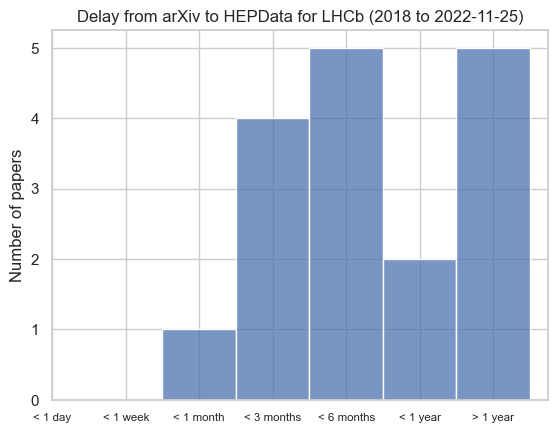

In [5]:
year = 2018
#year = 0  # all years
collaborations = ['ALICE', 'ATLAS', 'CMS', 'LHCb']
#collaborations = ['']  # all four main LHC collaborations
#collaborations = ['Belle-II']  # an experiment of your choice
for collaboration in collaborations:
    query = compose_query(collaboration, year)
    delays = calculate_delays(query)
    make_plot(delays, collaboration, year)